# VGG-16 Model 1a
## Preprocessing method: ImageDataGenerator()
## Image size: (98, 76) 
## Images: RGB
## Frozen pretrained layers except last 5 layers, Adam (1e-2)
## Image transformation

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [4]:
image_size = (98, 76)
batch_size = 64

datagen_transform = ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    rescale = 1./255,
)

train_ds = datagen_transform.flow_from_directory(
    path_training,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="rgb"
)

val_ds = datagen_transform.flow_from_directory(
    path_validation,
    seed=1993,
    target_size=image_size,
    batch_size=batch_size,
    classes=['female','male'],
    shuffle=True,
    color_mode="rgb"
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [5]:
vgg_model = keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg')
input_shape=(98,76, 3)


# Freeze the layers except the last 5
for layer in vgg_model.layers[:-5]:
    layer.trainable = False# 

# Create the first model
model = tf.keras.Sequential()# Add the VGG16 convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='sigmoid'))

## Compile and Summary
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,781,122
Trainable params: 7,145,602
Non-trainable params: 7,635,520
_________________________________________________________________


In [6]:
# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 1000     # Set epochs

vgg16_fit = model.fit(train_ds, 
                      epochs=epochs, 
                      validation_data=val_ds,
                      callbacks=[callback],
                      workers=12)

Epoch 1/1000
735/735 [==============================] - 81s 103ms/step - loss: 0.2820 - accuracy: 0.8849 - val_loss: 0.3314 - val_accuracy: 0.8614
Epoch 2/1000
735/735 [==============================] - 78s 104ms/step - loss: 0.2042 - accuracy: 0.9220 - val_loss: 0.2277 - val_accuracy: 0.9074
Epoch 3/1000
735/735 [==============================] - 77s 104ms/step - loss: 0.1825 - accuracy: 0.9306 - val_loss: 0.1977 - val_accuracy: 0.9248
Epoch 4/1000
735/735 [==============================] - 77s 104ms/step - loss: 0.1671 - accuracy: 0.9368 - val_loss: 0.5229 - val_accuracy: 0.9203
Epoch 5/1000
735/735 [==============================] - 77s 103ms/step - loss: 0.1587 - accuracy: 0.9416 - val_loss: 0.1702 - val_accuracy: 0.9343
Epoch 6/1000
735/735 [==============================] - 77s 104ms/step - loss: 0.1576 - accuracy: 0.9415 - val_loss: 0.1400 - val_accuracy: 0.9463
Epoch 7/1000
735/735 [==============================] - 77s 104ms/step - loss: 0.1527 - accuracy: 0.9434 - val_loss: 0

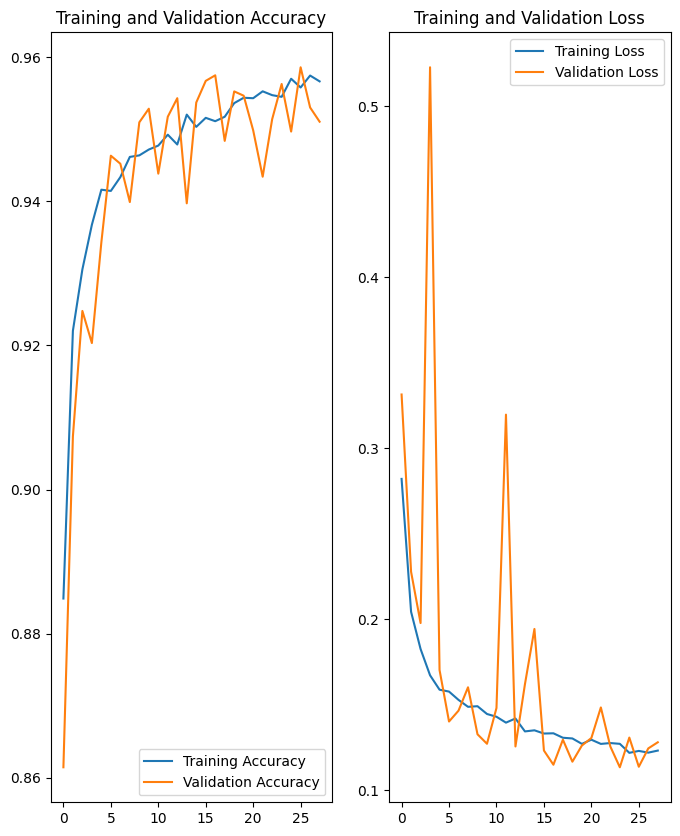

In [7]:
acc= vgg16_fit.history['accuracy']
val_acc = vgg16_fit.history['val_accuracy']

loss = vgg16_fit.history['loss']
val_loss = vgg16_fit.history['val_loss']

epochs_range = range(0, 28)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
print(str('Top Training Accuracy: ') + str(round(max(acc),4)))
print(str('Top Validation Accuracy: ') + str(round(max(val_acc),4)))

Top Training Accuracy: 0.9575
Top Validation Accuracy: 0.9586


In [9]:
model.save('GC weights/abhilasha/mod1c-RGB/mod1c_RGB_frozen.h5')